In [16]:
!pip install yfinance ta tensorflow scikit-learn matplotlib

In [17]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout

In [18]:
df = yf.download("AAPL", start="2015-01-01", auto_adjust=False)

df.columns = df.columns.get_level_values(0)

close = df["Close"]

df["rsi"] = ta.momentum.RSIIndicator(close).rsi()
df["macd"] = ta.trend.MACD(close).macd()
df["vol"] = df["Volume"]

df = df.dropna()

[*********************100%***********************]  1 of 1 completed


In [19]:
df["label"]=(df["Close"].shift(-1)>df["Close"]).astype(int)
df=df[:-1]

In [20]:
features=df[["Close","rsi","macd","vol"]].values
labels=df["label"].values.reshape(-1,1)

In [21]:
window=60
train_size=1000
test_size=50

In [22]:
def create_dataset(X,y,window):
    Xs,ys=[],[]
    for i in range(window,len(X)):
        Xs.append(X[i-window:i])
        ys.append(y[i])
    return np.array(Xs),np.array(ys)

In [23]:
from tensorflow.keras.layers import Input

def build_model(shape):
    model=Sequential([
        Input(shape=shape),

        Conv1D(64,3,activation="relu"),
        MaxPooling1D(2),
        Dropout(0.3),

        LSTM(64),
        Dropout(0.3),

        Dense(1,activation="sigmoid")
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [24]:
preds=[]
reals=[]
returns=[]

start=train_size

while start+test_size<len(features):

    trainX=features[:start]
    trainY=labels[:start]

    testX=features[start-window:start+test_size]
    testY=labels[start-window:start+test_size]

    scaler=MinMaxScaler()
    trainX=scaler.fit_transform(trainX)
    testX=scaler.transform(testX)

    X_train,y_train=create_dataset(trainX,trainY,window)
    X_test,y_test=create_dataset(testX,testY,window)

    model=build_model((window,X_train.shape[2]))
    model.fit(X_train,y_train,epochs=5,batch_size=32,verbose=0)

    prob=model.predict(X_test)
    pred=(prob>0.5).astype(int)

    preds.extend(pred.flatten())
    reals.extend(y_test.flatten())

    price_slice=df["Close"].values[start:start+len(pred)]
    ret=np.diff(price_slice)/price_slice[:-1]
    returns.extend(ret*pred.flatten()[:-1])

    start+=test_size

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

In [25]:
print("Accuracy:",accuracy_score(reals,preds))

Accuracy: 0.5308571428571428


In [26]:
returns=np.array(returns)

sharpe=returns.mean()/returns.std()*np.sqrt(252)
cum=np.cumsum(returns)

peak=np.maximum.accumulate(cum)
drawdown=cum-peak
mdd=drawdown.min()

print("Sharpe:",sharpe)
print("Max Drawdown:",mdd)

Sharpe: 0.9418275840116985
Max Drawdown: -0.36535903965129934


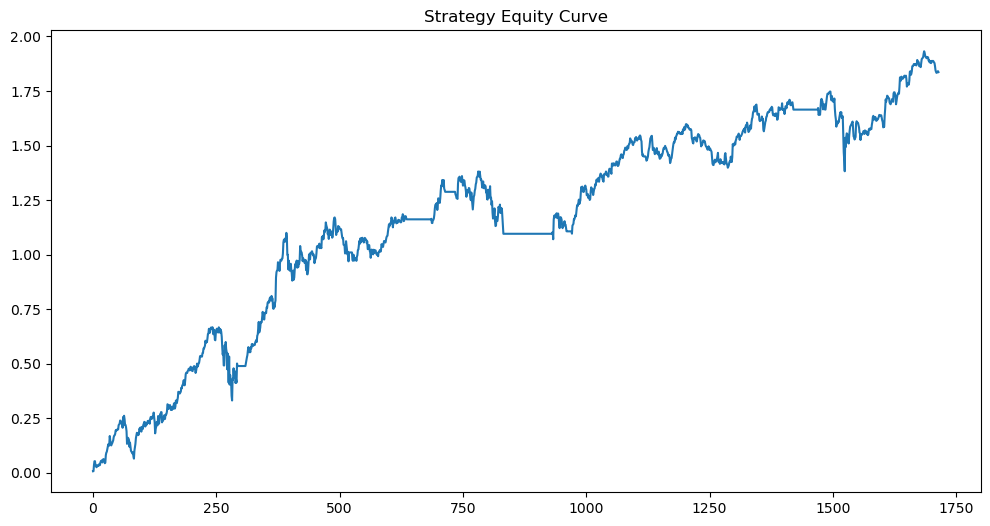

In [27]:
plt.figure(figsize=(12,6))
plt.plot(np.cumsum(returns))
plt.title("Strategy Equity Curve")
plt.show()